In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster, progress
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
import s3fs
from glob import glob
%matplotlib inline

# Set random seed
seed = 3985
np.random.seed(seed)
random.seed(seed)

In [2]:
# How to load the data from disk or cloud

def split_data_files(dir_path="ncar-aiml-data-commons/goes/ABI_patches_32/", file_prefix='abi_patches_', 
               start_date='20190302', end_date='20191001', seq_len=4, skip_len=1):
    """
    Take daily ABI patch files and split into equal training/validation/testing
    semi-contiguous partitions, skipping day(s) between chunks to isolate convective 
    cycles.
    
    Args: 
        dir_path: (str) Directory path to daily ABI files
        file_prefix: (str) File prefix up to date 
        start_date: (str) Starting date to get files in format of YYYYMMDD
        end_date: (str) Ending date to get files in format of YYYYMMDD
        seq_len: (int) Length of days per 'chunk' of data
        skip_len: (int) How many days to skip between data chunks
        
    Returns:
        train_f, val_f, test_f: list of training/validation/test files
    """
    
    all_files = fs.ls(dir_path)
    start_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, start_date))
    end_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, end_date))
    file_spread = all_files[start_index:end_index+1]
    
    train_files, val_files, test_files = [], [], []
    
    for i in np.arange(0, len(file_spread)+1, (seq_len+skip_len)*3):
        
        val_i = i + seq_len + skip_len
        test_i = i + (seq_len + skip_len)*2
        
        train_files.append(file_spread[i:i+seq_len])
        val_files.append(file_spread[val_i:val_i+seq_len])
        test_files.append(file_spread[test_i:test_i+seq_len])
        
    train_f = [item for sublist in train_files for item in sublist]
    val_f = [item for sublist in val_files for item in sublist]
    test_f = [item for sublist in test_files for item in sublist]
    
    return train_f, val_f, test_f

def fetch_data(file_number, file_list):
    """
    Function to be distributed across a cluster to individually load files directly from an AWS S3 bucket 
    
    Args:
        file_number: index for file from file_list
        file_list: List of files to index from
    Returns:
        ds: xarray dataset of daily file 
    """
    obj = fs.open(file_list[file_number])
    ds = xr.open_dataset(obj, chunks={})
    
    return ds

def merge_data(file_list):
    """
    Take a list of files and distribute across a cluster to be loaded then gathered and concantenated
    
    Args:
        file_list: List of files to be merged together (training, validation, or testing)
    Returns:
        merged_data: Concatenated xarray dataset of training, validation, or testing data 
    """
    futures = client.map(fetch_data, range(len(file_list)), [file_list]*len(file_list))
    results = client.gather(futures)
    merged_data = xr.concat(results, 'patch').compute()
    
    return merged_data

def prepare_data(data):
    """
    Take GOES netCDF data, filter out NaNs, reshape for tensorflow, convert flash_counts to binary,
    and return filtered numpy arrays
    Args:
        data: GOES patch netCDF data including ABI bands and lightning flash counts
    Returns:
        good_imagery: NaN filtered numpy array with reshaped dimensions (patch, x, y, band)
        binary_output: 1D numpy array of lightnin flash_counts
    """
    
    input_data = np.moveaxis(data['abi'].values, 1, -1)
    output_data = data['flash_counts'].values
    
    nan_indices = np.unique(np.where(np.isnan(input_data))[0])
    all_indices = np.arange(input_data.shape[0])
    valid_indices = all_indices[np.isin(all_indices, nan_indices, assume_unique=True, invert=True)]
    
    good_imagery = input_data[valid_indices]
    binary_output = np.where(output_data > 0, 1, 0)[valid_indices]
    
    return good_imagery, binary_output

In [3]:
%%time
cluster = LocalCluster(processes=True, threads_per_worker=2)
client = Client(cluster)
fs = s3fs.S3FileSystem(anon=True)

# Split into training, validation, and test sets
# We only load the train and val sets here to save a couple minutes
train_files, val_files, test_files = split_data_files(start_date='20190601', end_date='20190801')
train, val = map(merge_data, [train_files, val_files])

CPU times: user 7.93 s, sys: 9.68 s, total: 17.6 s
Wall time: 1min 28s


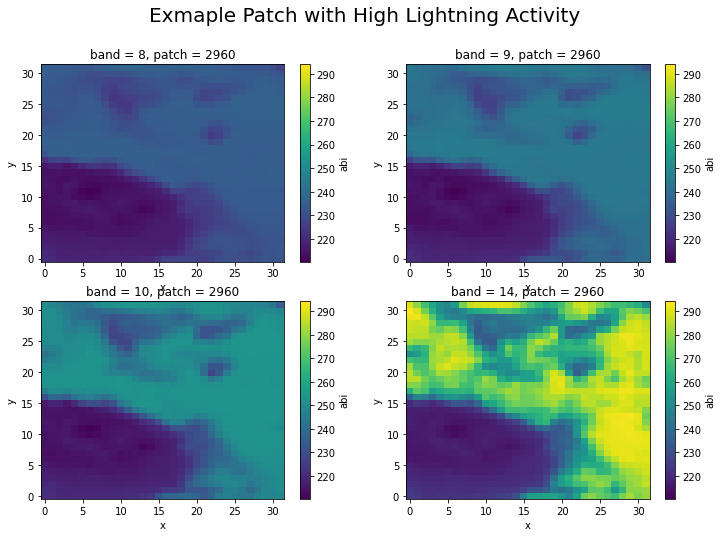

In [4]:
high_lc_indices = np.argwhere(train.flash_counts.values > 100).flatten() # indices with more than 100 lightning counts
no_lc_indices = np.argwhere(train.flash_counts.values == 0).flatten() # indices with no lightning counts

index = high_lc_indices[333]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range  
vmax = train['abi'][index,:,:,:].max()

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch with High Lightning Activity', fontsize=20)

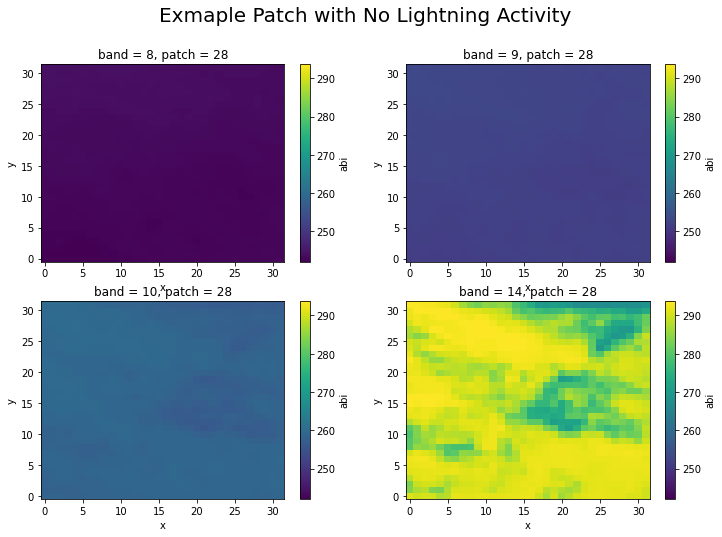

In [5]:
index = no_lc_indices[3]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range
vmax = train['abi'][index,:,:,:].max() # set min/max plotting range

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch with No Lightning Activity', fontsize=20)

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


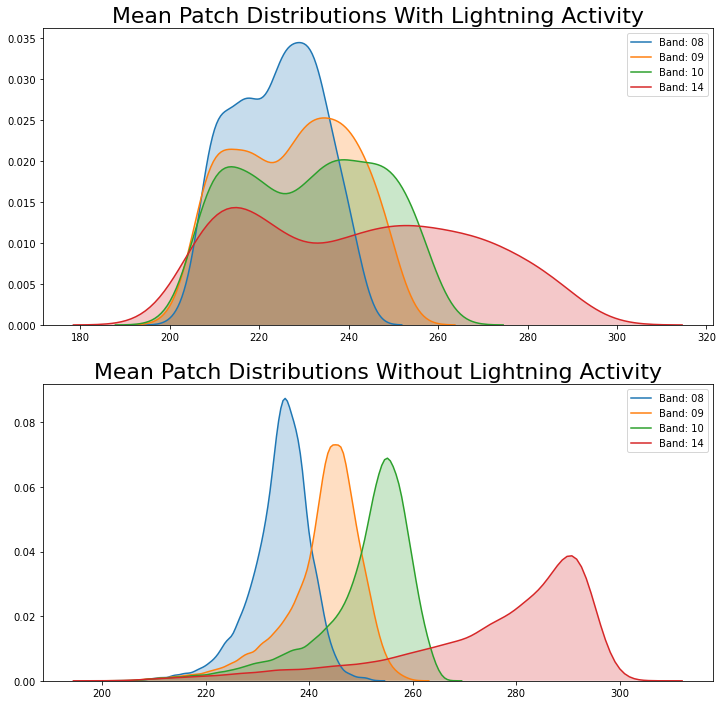

In [6]:
lc_train = train.isel(patch=high_lc_indices) # all patch data with lightning counts (above threshold)
no_lc_train = train.isel(patch=no_lc_indices) # all patch data without lightning activity
mean_patches_lc = lc_train.abi.mean(dim=('x','y')) # mean BT of each patch
mean_patches_no_lc = no_lc_train.abi.mean(dim=('x','y')) # mean BT of each patch

fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
    if i < 4:
        sns.kdeplot(mean_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'Mean Patch Distributions With Lightning Activity', fontsize=22)
    else:
        sns.kdeplot(mean_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'Mean Patch Distributions Without Lightning Activity', fontsize=22)

Get the data froim the xarray objects and split between input and output for train and val sets.

In [7]:
train_mean = train.mean(dim=('x','y')).dropna(dim='patch')
train_in = pd.DataFrame(train_mean['abi'].values)
train_out = train_mean['flash_counts'].values
train_out = np.where(train_out > 0, 1, 0)

val_mean = val.mean(dim=('x','y')).dropna(dim='patch')
val_in = pd.DataFrame(val_mean['abi'].values)
val_out = val_mean['flash_counts'].values
val_out = np.where(val_out > 0, 1, 0)

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [8]:
train_in.shape, train_out.shape, val_in.shape, val_out.shape

((63300, 4), (63300,), (56800, 4), (56800,))

In [9]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor

scaler = StandardScaler()

It is often helpful to have a persistance model - a very basic model - to compare results to. Here our persistance model will just always predict the majority class.  Now we have a metric to compare to to make sure we're making progress.

In [12]:
# this is just comaring our True output compared to always predicting Zero (the majority of cases)
print('Mean squared error: %.4f'
      % mean_squared_error(val_out, np.zeros(len(val_out)),squared=False))

Mean squared error: 0.6669


Perform Linear regression using the mean valus for each patch (for each band) as predictors. Much better than persistance model!

In [13]:
# Create linear regression object
mod = linear_model.LinearRegression()

# Train the model using the training sets
mod.fit(train_in, train_out)

# make predictions
preds = mod.predict(val_in)

print('Mean squared error: %.4f'
      % mean_squared_error(val_out, preds, squared=False))


Mean squared error: 0.4057


Perform Pricipal Component Analysis (PCA) to reduce dimensions of full data set. First well reshape the data into 2D data which the PCA function needs. Between the 4 bands and 32x32 patches we end up with 4096 features... Certainly enough to be reduced.

In [14]:
# reshape train and val sets for pca; display dimensions
t = np.array(train['abi'].values)
train_reshape = pd.DataFrame(t.reshape(t.shape[0], t.shape[1]*t.shape[2]*t.shape[3])).dropna()

v = np.array(val['abi'].values)
val_reshape = pd.DataFrame(v.reshape(v.shape[0], v.shape[1]*v.shape[2]*v.shape[3])).dropna()

train_reshape.shape, val_reshape.shape

((63300, 4096), (56800, 4096))

Perform Principal component analysis. We'll try to reduce down to 10 dimensions. We'll scale the data first.

In [15]:
pca = PCA(n_components=10)
pca_train_in = scaler.fit_transform(pca.fit_transform(train_reshape))
pca_val_in = scaler.transform(pca.transform(val_reshape))

pca_train_in.shape, pca_val_in.shape

((63300, 10), (56800, 10))

Now we'll try a logistic regression model on the PCA input data. Slightly better reults, but not by much (as far as this metric goes anyway).

In [16]:
logistic_mod = linear_model.LogisticRegression()
logistic_mod.fit(pca_train_in, train_out)

preds = logistic_mod.predict_proba(pca_val_in)[:,1]

print('Mean squared error: %.4f'
      % mean_squared_error(val_out, preds, squared=False))

Mean squared error: 0.4031


Try a Decision Tree Model... (Random Forest).  Better results!

In [19]:
rf_mod = RandomForestRegressor()

# Train the model using the training sets
rf_mod.fit(pca_train_in, train_out)

preds = rf_mod.predict(pca_val_in)

print('Mean squared error: %.4f'
      % mean_squared_error(val_out, preds, squared=False))

Mean squared error: 0.3520
